In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = True
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-11-10 00:07:57.985694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1892] Ignoring visible gpu device (device: 0, name: Quadro K2000, pci bus id: 0000:05:00.0, compute capability: 3.0) with Cuda compute capability 3.0. The minimum required Cuda capability is 3.5.


# Load data from the output of Brusselator model

In [2]:
import os

In [3]:
data_path = pathlib.PurePath(os.path.abspath("../../test/outputs_Brusselator_32_by_32/Brusselator_2"))
with open(data_path.joinpath(f"Brusselator_2.npy"), "rb") as f:
    data = np.load(f)
with open(data_path.joinpath("simulation.txt"), "r") as f:
    simulation = eval(f.read())

In [4]:
dataset = TINN_Single_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator_32_by_32/Brusselator_2"),
                                "Brusselator_2", thining_start=-3)

In [5]:
thining_start = -3
t_star = np.linspace(simulation.t_start, simulation.t_end, simulation.t_steps)
# Thining the dataset
t_star = t_star[thining_start:]
data = data[..., thining_start:]

In [6]:
data.shape

(2, 32, 32, 3)

In [7]:
L = 2
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size * y_size
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)

T = t_star.shape[0]
X, Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")


In [8]:
t_star

array([125.98425197, 126.99212598, 128.        ])

In [9]:
class NN2(tf.Module):
    def __init__(self, layers, L, n, t, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(**kwargs)
        self.layers = layers
        self.num_layers = len(self.layers)
        self.L = tf.expand_dims(L, axis=0)
        self.n = n
        self.t = t
        self.dtype = dtype
        self.__version__ = 0.1
        self.build()

    def build(self):
        """Create the state of the layers (weights)"""
        x = tf.linspace(0, self.L[0][0], self.n[0])
        y = tf.linspace(0, self.L[0][1], self.n[1])
        X, Y, T = tf.meshgrid(x, y , self.t)
        self.domain = tf.concat([tf.expand_dims(tf.reshape(X, [-1]),axis=1),
                                 tf.expand_dims(tf.reshape(Y, [-1]), axis=1),
                                 tf.expand_dims(tf.reshape(T, [-1]), axis=1)], axis=1)
        
        self.lb = tf.concat([tf.cast(self.L, self.dtype), 
                             tf.reshape(tf.reduce_min(self.t), [1, 1])], axis=1)
        
        weights = []
        biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            weights.append(W)
            biases.append(b)

        self.Ws = weights
        self.bs = biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(
            tf.compat.v1.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=self.dtype), dtype=self.dtype
        )

    @tf.function
    def net(self, dummy):     
        
        
        
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (self.domain / self.lb) - 1.0
        for W, b in zip(self.Ws[:-1], self.bs[:-1]):
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

        W = self.Ws[-1]
        b = self.bs[-1]
        outputs = tf.add(tf.matmul(H, W), b)
        return outputs

    def __call__(self, dummy):
        """Defines the computation from inputs to outputs

        Args:
           t: time.

        Return:
                A tensor of the dense layer output that has a shape
                [None, Dn], where Dn is the dimensionality of the last
                layer, specificed by the last elements of the layer
                arguemnt.
        """       
        return self.net(dummy)

    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: inputs.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.

        Return:   The returns 'partial_1' and 'partial_2' are the first and second
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]

        """                
        partials_1 = [tf.gradients(outputs[:, i], self.domain)[0] for i in range(outputs.shape[1])]
        #print(partials_1)
        partials_2 = [tf.gradients(partials_1[i], self.domain)[0] for i in range(outputs.shape[1])]
        #print(partials_2)
        return partials_1, partials_2

    def gradients_tape(self, inputs, outputs, tape):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.
           tape:   Gradient Tape object, for eager mode.
                   The outputs must be the list
                   of Tensors.

        Return:   The returns 'partial' gradients. It is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, the list has Dn tensors as an elements. The dimensionality
                  of the tensors is the same as inputs: [None, D1]

        """        
        partials = [tape.gradient(outputs[i], self.domain) for i in range(len(outputs))]
        return partials

    def copy(self):
        return copy.deepcopy(self)


In [10]:
from turing.loss_functions import PDE_Parameter, Parameter_Type
#from turing.utils import Simulation

In [11]:
layers = [3, 256, 256, 256, 256, 2]
pinn = NN2(layers, L=(2,2), n=(100,100), t=t_star, dtype=tf.float64)

In [11]:
pinn.lb

<tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[  2.        ,   2.        , 510.01165049]])>

In [12]:
pinn.domain.numpy()[:10]

array([[0.00000000e+00, 0.00000000e+00, 5.10011650e+02],
       [0.00000000e+00, 0.00000000e+00, 5.11005825e+02],
       [0.00000000e+00, 0.00000000e+00, 5.12000000e+02],
       [2.02020202e-02, 0.00000000e+00, 5.10011650e+02],
       [2.02020202e-02, 0.00000000e+00, 5.11005825e+02],
       [2.02020202e-02, 0.00000000e+00, 5.12000000e+02],
       [4.04040404e-02, 0.00000000e+00, 5.10011650e+02],
       [4.04040404e-02, 0.00000000e+00, 5.11005825e+02],
       [4.04040404e-02, 0.00000000e+00, 5.12000000e+02],
       [6.06060606e-02, 0.00000000e+00, 5.10011650e+02]])

In [13]:
pinn.net(0)

2022-11-09 08:57:38.438769: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


<tf.Tensor: shape=(30000, 2), dtype=float64, numpy=
array([[ 0.06219485,  0.19202625],
       [ 0.06227903,  0.19230783],
       [ 0.06236314,  0.19258923],
       ...,
       [-0.01159643, -0.03504896],
       [-0.01148971, -0.03474414],
       [-0.01138298, -0.03443942]])>

In [14]:
t_star

array([510.01165049, 511.00582524, 512.        ])

In [12]:
#layers = [5, 128, 128, 128, 128, 2]
#layers = [3, 256, 256, 256, 256, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
#pinn = tu.NN2(layers, dataset.lb, dataset.ub, dtype=tf.float64)

pde_loss = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulation.Ds[0],dtype=pinn.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulation.Ds[1],dtype=pinn.dtype),
                       A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.VARIABLE, dataset.simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn.dtype)
                       #B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm = L2()
l_inf_norm = L_Inf()

In [13]:
optimizer=keras.optimizers.Adam(learning_rate=5e-4)

In [18]:
@tf.function
def train_step(pinn, loss,  Y, norm, optimizer):
    with tf.GradientTape(persistent=True) as tape:
        outputs, fu, fv = loss.residual(pinn, 0)        
        loss_obs = norm.norm(Y - outputs)
        loss_res_u = norm.norm(fu)
        loss_res_v = norm.norm(fv)
        loss_value = loss_obs #+ loss_res_u + loss_res_v
        trainables = pinn.trainable_variables + loss.trainables()
    grads = tape.gradient(loss_value, trainables)
    optimizer.apply_gradients(zip(grads, trainables))
    return loss_value, loss_obs, loss_res_u, loss_res_v
    

In [20]:
#ds = [data[..., t].reshape(data.shape[0],data.shape[1]*data.shape[2]) for t in range(data.shape[3])]
#ds = np.concatenate(ds, axis=1).T
ds = np.array([data[c,...].reshape(data.shape[1]*data.shape[2]*data.shape[3]) for c in range(data.shape[0])]).T

In [21]:
ds.shape

(30000, 2)

In [22]:

l = np.array([train_step(pinn, pde_loss, ds, l2_norm+l_inf_norm, optimizer) for epoch in range(100)])

2022-11-09 08:58:03.089944: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2022-11-09 09:02:48.553365: W tensorflow/core/common_runtime/bfc_allocator.cc:431] Allocator (GPU_0_bfc) ran out of memory trying to allocate 58.59MiB (rounded to 61440000)requested by op PartitionedCall/gradients/gradients/StatefulPartitionedCall_grad/PartitionedCall_grad/PartitionedCall/gradients/gradients/MatMul_grad/MatMul_grad/MatMul
Current allocation summary follows.
2022-11-09 09:02:48.553526: I tensorflow/core/common_runtime/bfc_allocator.cc:970] BFCAllocator dump for GPU_0_bfc
2022-11-09 09:02:48.553553: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (256): 	Total Chunks: 377, Chunks in use: 376. 94.2KiB allocated for chunks. 94.0KiB in use in bin. 2.9KiB client-requested in use in bin.
2022-11-09 09:02:48.553571: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-11-09 09:02:48.553589: I tensorflow/core/common_runtime/bfc_allocator

2022-11-09 09:02:58.567500: W tensorflow/core/common_runtime/bfc_allocator.cc:431] Allocator (GPU_0_bfc) ran out of memory trying to allocate 58.59MiB (rounded to 61440000)requested by op PartitionedCall/gradients/gradients_1/StatefulPartitionedCall_grad/PartitionedCall_grad/PartitionedCall/gradients/gradients/MatMul_grad/MatMul_grad/MatMul
Current allocation summary follows.
2022-11-09 09:02:58.567582: I tensorflow/core/common_runtime/bfc_allocator.cc:970] BFCAllocator dump for GPU_0_bfc
2022-11-09 09:02:58.567608: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (256): 	Total Chunks: 377, Chunks in use: 376. 94.2KiB allocated for chunks. 94.0KiB in use in bin. 2.9KiB client-requested in use in bin.
2022-11-09 09:02:58.567628: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-11-09 09:02:58.567647: I tensorflow/core/common_runtime/bfc_allocat

2022-11-09 09:03:08.582112: W tensorflow/core/common_runtime/bfc_allocator.cc:431] Allocator (GPU_0_bfc) ran out of memory trying to allocate 58.59MiB (rounded to 61440000)requested by op StatefulPartitionedCall/gradients_3/gradients_1/StatefulPartitionedCall_grad/PartitionedCall_grad/PartitionedCall/gradients/gradients/Tanh_grad/TanhGrad_grad/TanhGrad
Current allocation summary follows.
2022-11-09 09:03:08.582186: I tensorflow/core/common_runtime/bfc_allocator.cc:970] BFCAllocator dump for GPU_0_bfc
2022-11-09 09:03:08.582212: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (256): 	Total Chunks: 377, Chunks in use: 376. 94.2KiB allocated for chunks. 94.0KiB in use in bin. 2.9KiB client-requested in use in bin.
2022-11-09 09:03:08.582231: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-11-09 09:03:08.582250: I tensorflow/core/common_runtime

2022-11-09 09:03:18.597315: W tensorflow/core/common_runtime/bfc_allocator.cc:431] Allocator (GPU_0_bfc) ran out of memory trying to allocate 58.59MiB (rounded to 61440000)requested by op StatefulPartitionedCall/gradients_2/gradients/StatefulPartitionedCall_grad/PartitionedCall_grad/PartitionedCall/gradients/gradients/MatMul_1_grad/MatMul_grad/MatMul
Current allocation summary follows.
2022-11-09 09:03:18.597390: I tensorflow/core/common_runtime/bfc_allocator.cc:970] BFCAllocator dump for GPU_0_bfc
2022-11-09 09:03:18.597415: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (256): 	Total Chunks: 377, Chunks in use: 376. 94.2KiB allocated for chunks. 94.0KiB in use in bin. 2.9KiB client-requested in use in bin.
2022-11-09 09:03:18.597435: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-11-09 09:03:18.597454: I tensorflow/core/common_runtime/b

ResourceExhaustedError:  OOM when allocating tensor with shape[30000,256] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node PartitionedCall/gradients/gradients/StatefulPartitionedCall_grad/PartitionedCall_grad/PartitionedCall/gradients/gradients/MatMul_grad/MatMul_grad/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_step_29511]

Function call stack:
train_step


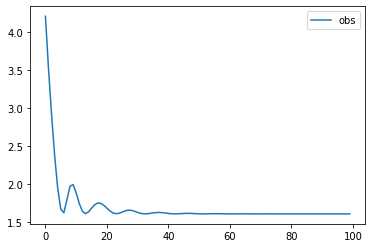

In [85]:
#plt.plot(l[:,0], label="total")
plt.plot(l[:,1], label="obs")
#plt.plot(l[:,2], label="res u")
#plt.plot(l[:,3], label="res v")
plt.legend()
#plt.yscale('log')

In [65]:
optimizer.lr.assign(1e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [66]:
l2 = np.array([train_step(pinn, pde_loss, ds, l2_norm, optimizer) for epoch in range(100)])

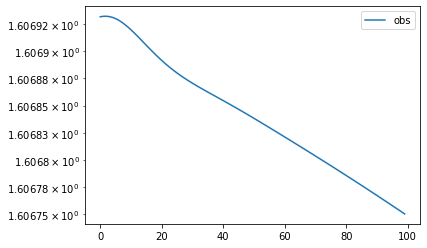

In [67]:
#plt.plot(l2[:,0], label="total")
plt.plot(l2[:,1], label="obs")
#plt.plot(l2[:,2], label="res u")
#plt.plot(l2[:,3], label="res v")
plt.legend()
plt.yscale('log')

In [58]:
x_domain = dataset.simulation.L[0] * np.linspace(0, 1, dataset.simulation.n[0])
y_domain = dataset.simulation.L[1] * np.linspace(0, 1, dataset.simulation.n[1])
x_size = dataset.simulation.n[0]
y_size = dataset.simulation.n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ts[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ts[T_test_index], N2)  # 1 x N2

#A_test = np.repeat(dataset.simulation.parameters["A"]+1, N2)
#B_test = np.repeat(dataset.simulation.parameters["B"]+1, N2)

512.0


In [59]:
pinn.net(0).shape

TensorShape([30000, 2])

In [86]:
#output_test = pinn(np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T)
output_test = pinn.net(0)
#output_test = output_test[:, 1].numpy().reshape((2, x_size, y_size))
output_test = np.array([ output_test[:, i].numpy()[::len(t_star)].reshape((x_size, y_size)) for i in range(2)]) 

In [87]:
output_test.shape

(2, 100, 100)

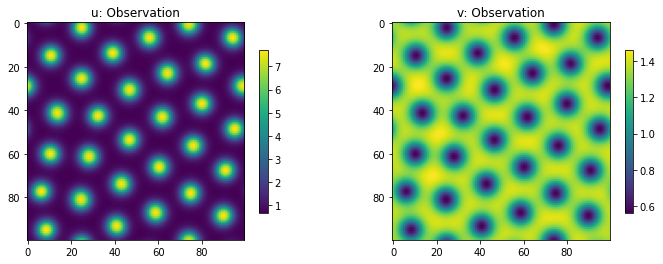

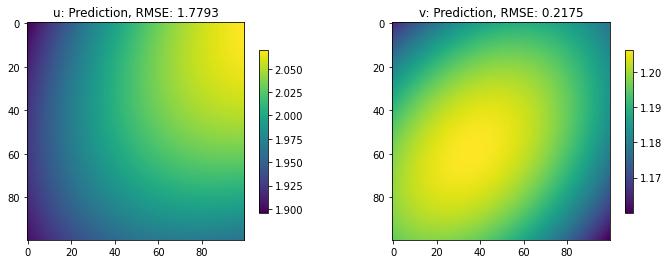

In [88]:
node_names = ["u", "v"]
_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [53]:
#test_d = np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T
test_d = np.vstack([XX_test, YY_test, TT_test]).T
test_outputs = np.zeros((test_d.shape[0], len(node_names)))
test_pde_u = np.zeros(test_d.shape[0])
test_pde_v = np.zeros(test_d.shape[0])

for i, _ in enumerate(test_d):
    outs, pde_u, pde_v = pde_loss.residual(pinn, test_d[i:(i+1), ...])
    test_outputs[i] = outs.numpy()
    test_pde_u[i] = pde_u.numpy()
    test_pde_v[i] = pde_v.numpy()


In [54]:
test_outputs = np.array([ test_outputs[:, i].reshape((x_size, y_size)) for i in range(test_outputs.shape[1])]) 
test_pde_u = test_pde_u.reshape((x_size, y_size))
test_pde_v = test_pde_v.reshape((x_size, y_size))

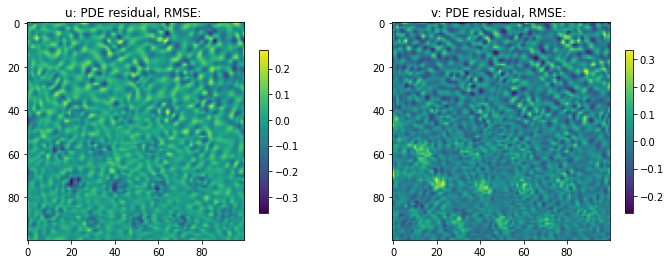

In [55]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title(f"u: PDE residual, RMSE: ")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
plt.title(f"v: PDE residual, RMSE: ")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

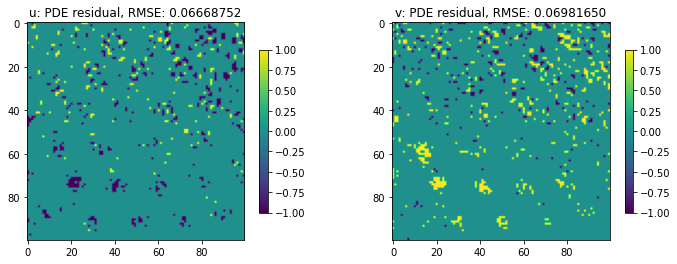

In [58]:
max_L = .12
min_L = -.12

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()

# Parameters estimation

In [2]:
import os

In [3]:
dataset = TINN_Single_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator_32_by_32/Brusselator_2"),
                                 "Brusselator_2",
                                 thining_start=-2)

In [4]:
#layers = [5, 128, 128, 128, 128, 2]
#layers = [3, 256, 256, 256, 256, 2]
layers = [3, 512, 512, 128, 128, 128, 128, 128, 128, 128, 128, 128, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
pinn2 = tu.Res_NN(layers, dataset.lb, dataset.ub, dtype=tf.float64)
pde_loss2 = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulation.Ds[0],dtype=pinn2.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulation.Ds[1],dtype=pinn2.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn2.dtype),
                       A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinn2.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       #B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn2.dtype)
                       B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinn2.dtype) 
                       #B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm2 = L2()
l_inf_norm2 = L_Inf()

In [5]:
optimizer2=keras.optimizers.Adam(learning_rate=1e-4)

In [6]:
model2 = tu.TINN(pinn2, 
                pde_loss2, 
                loss = l2_norm2+ l_inf_norm2,
                #non_zero_loss=pde_non_zero, 
                optimizer=optimizer2,
                alpha = 0.2,
                loss_penalty_power=1,
                print_precision=".10f")

In [7]:
dataset.x_size

2048

In [8]:
results2_1 = model2.train(epochs=10000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=500,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval=10,
                     )


Start of epoch 0
Training observations acc over epoch: 8.2414741516
total loss: 35.6523337882, total regularisd loss (sum of batches): 142.6093351528
obs u loss: 24.4641886594, obs v loss: 8.5017080207
pde u loss: 2.1984550136, pde v loss: 0.4879820945
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000
A: 0.99966 B: 0.99964 
Time taken: 118.02s

Start of epoch 500
Training observations acc over epoch: 5.6929974556
total loss: 23.7908447725, total regularisd loss (sum of batches): 351.7908618892
obs u loss: 22.2791210349, obs v loss: 0.4928696028
pde u loss: 0.6635467127, pde v loss: 0.3553074220
lambda obs u: 3.9462373326, lambda obs v: 0.0305182693
lambda pde u: 0.0141628487, lambda pde v: 0.0090815494
A: 0.96845 B: 1.05566 
Time taken: 680.49s

Start of epoch 1000
Training observations acc over epoch: 5.6633186340
total loss: 23.4456965635, total regularisd loss (sum of batches): 349.0874498014
obs u loss: 22.2292415122, obs


Start of epoch 9500
Training observations acc over epoch: 2.5630888939
total loss: 19.5244553711, total regularisd loss (sum of batches): 119.0811976157
obs u loss: 9.7834065469, obs v loss: 0.4689490534
pde u loss: 4.8836765086, pde v loss: 4.3884232622
lambda obs u: 2.9513168800, lambda obs v: 0.7362415767
lambda pde u: 0.1749861594, lambda pde v: 0.1374553840
A: 0.02293 B: 2.34246 
Time taken: 614.66s

Start of epoch 10000
Training observations acc over epoch: 2.1955780983
total loss: 22.5859824235, total regularisd loss (sum of batches): 112.7641862575
obs u loss: 8.1990224244, obs v loss: 0.5832900010
pde u loss: 7.2782335326, pde v loss: 6.5254364655
lambda obs u: 2.8374981489, lambda obs v: 0.6894057359
lambda pde u: 0.3265984103, lambda pde v: 0.1464977049
A: 0.05008 B: 2.34923 
Time taken: 618.41s


In [ ]:
plot_result(results2_1, param_names=["A", "B"])

In [ ]:
print(f"A = {pde_loss2.A.tf_var.numpy()[0]:.16f}")
print(f"B = {pde_loss2.B.tf_var.numpy()[0]:.16f}")

In [ ]:
dataset.simulation.parameters

In [21]:
x_domain = dataset.simulation.L[0] * np.linspace(0, 1, dataset.simulation.n[0])
y_domain = dataset.simulation.L[1] * np.linspace(0, 1, dataset.simulation.n[1])
x_size = dataset.simulation.n[0]
y_size = dataset.simulation.n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ts[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ts[T_test_index], N2)  # 1 x N2

A_test = np.repeat(dataset.simulation.parameters["A"]+1, N2)
B_test = np.repeat(dataset.simulation.parameters["B"]+1, N2)

128.0


In [22]:
output_test = pinn2(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

In [23]:
import os
data_path = os.path.abspath("../../test/outputs_Brusselator_100_by_100/Brusselator_1/Brusselator_1.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data = data[...,-2:]

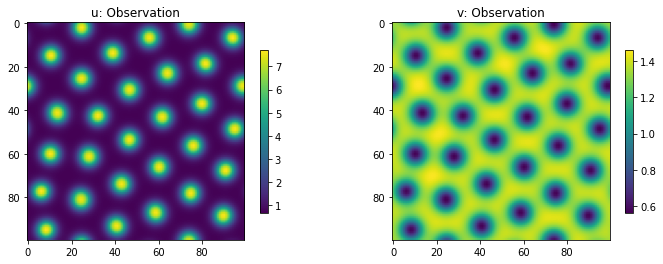

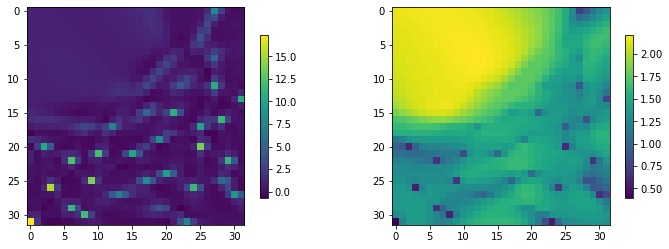

In [24]:
node_names = ["u", "v"]
_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    #rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    #plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [30]:
test_outputs, test_pde_u, test_pde_v = pde_loss2.residual(pinn2, np.vstack([XX_test, YY_test, TT_test]).T)
test_outputs = test_outputs.numpy()
test_pde_u = test_pde_u.numpy().reshape((x_size, y_size))
test_pde_v = test_pde_v.numpy().reshape((x_size, y_size))

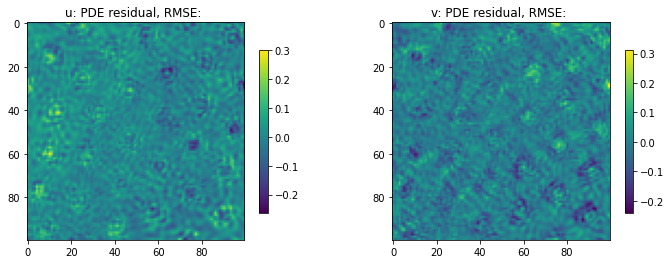

In [32]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title(f"u: PDE residual, RMSE: ")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
plt.title(f"v: PDE residual, RMSE: ")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

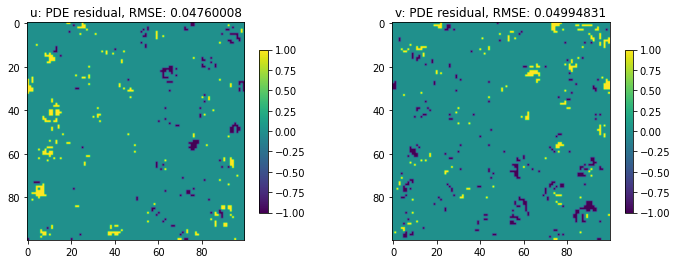

In [33]:
max_L = .10
min_L = -.10

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()

# Parameters as input

In [2]:
import os
dataset = TINN_Multiple_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator_100_by_100_dense"),
                                 ["Brusselator_1"] +
                                 [f"Brusselator_1_{id}" for id in range(1,61)],
                                 param_names = ["A", "B"],
                                 pde_ratio = 0,
                                 thining_start=-2)

In [3]:
dataset.x_size

1220000

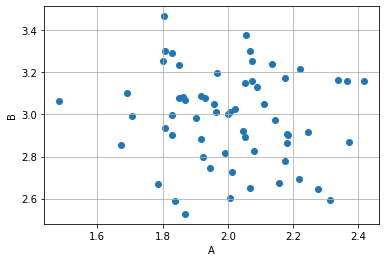

In [4]:
As = [s.parameters["A"] for s in dataset.simulations]
Bs = [s.parameters["B"] for s in dataset.simulations]
plt.scatter(As, Bs)
plt.xlabel("A")
plt.ylabel("B")
plt.grid()
plt.show()

In [5]:
#layers = [5, 128, 128, 128, 128, 2]
layers = [5, 256, 256, 256, 256, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
pinn3 = tu.NN(layers, dataset.lb, dataset.ub, dtype=tf.float64)
pde_loss3 = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulations[0].Ds[0],dtype=pinn3.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulations[0].Ds[1],dtype=pinn3.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn3.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinn3.dtype),
                       A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       #B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn3.dtype)
                       #B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinn3.dtype) 
                       B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm3 = L2()
l_inf_norm3 = L_Inf()

In [6]:
model3 = tu.TINN(pinn3, 
                pde_loss3, 
                loss = l2_norm3+ l_inf_norm3,
                #non_zero_loss=pde_non_zero, 
                alpha = 0.2,
                loss_penalty_power=1,
                print_precision=".10f")

In [7]:
dataset = dataset.cache()

In [8]:
results3_1 = model3.train(epochs=2000+1,
                      batch_size=dataset.x_size//380,
                      dataset=dataset,
                      print_interval=10,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 20
                     )


Start of epoch 0


2022-10-25 16:54:14.289397: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-25 16:54:26.950497: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 1.6530870199
total loss: 6.9169794368, total regularisd loss (sum of batches): 2636.0631352606
obs u loss: 6.3364546754, obs v loss: 0.2758937765
pde u loss: 0.1407621626, pde v loss: 0.1638688222
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000

Time taken: 151.47s

Start of epoch 10
Training observations acc over epoch: 1.5920084715
total loss: 6.3995398850, total regularisd loss (sum of batches): 2439.3650864083
obs u loss: 6.1481721523, obs v loss: 0.2198615170
pde u loss: 0.0215402650, pde v loss: 0.0099659507
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000

Time taken: 317.21s

Start of epoch 20
Training observations acc over epoch: 1.5918910503
total loss: 6.3964524928, total regularisd loss (sum of batches): 2438.1937210718
obs u loss: 6.1475305056, obs v loss: 0.2200321439
pde u loss: 0.0202191470, pde v loss: 0.008670


Start of epoch 220
Training observations acc over epoch: 0.1004494280
total loss: 1.9002548007, total regularisd loss (sum of batches): 480.4835425997
obs u loss: 0.3300951770, obs v loss: 0.0717026496
pde u loss: 0.7611256117, pde v loss: 0.7373313625
lambda obs u: 1.9913089330, lambda obs v: 1.3443700484
lambda pde u: 0.3173374009, lambda pde v: 0.3469836177

Time taken: 394.59s

Start of epoch 230
Training observations acc over epoch: 0.0972554460
total loss: 1.8379153961, total regularisd loss (sum of batches): 460.9317989861
obs u loss: 0.3192731234, obs v loss: 0.0697486675
pde u loss: 0.7309814705, pde v loss: 0.7179121346
lambda obs u: 1.9913089330, lambda obs v: 1.3443700484
lambda pde u: 0.3173374009, lambda pde v: 0.3469836177

Time taken: 311.70s

Start of epoch 240
Training observations acc over epoch: 0.0939480960
total loss: 1.7923214690, total regularisd loss (sum of batches): 447.0453345112
obs u loss: 0.3070504384, obs v loss: 0.0687419320
pde u loss: 0.7164480774, p


Start of epoch 440
Training observations acc over epoch: 0.0658497214
total loss: 1.2543070838, total regularisd loss (sum of batches): 295.8402871995
obs u loss: 0.2138059572, obs v loss: 0.0495929763
pde u loss: 0.4871784499, pde v loss: 0.5037297004
lambda obs u: 1.7441097607, lambda obs v: 1.6046013562
lambda pde u: 0.3302311975, lambda pde v: 0.3210576856

Time taken: 394.61s

Start of epoch 450
Training observations acc over epoch: 0.0652208701
total loss: 1.2427952027, total regularisd loss (sum of batches): 292.2581465893
obs u loss: 0.2119532768, obs v loss: 0.0489302329
pde u loss: 0.4826421902, pde v loss: 0.4992695028
lambda obs u: 1.7441097607, lambda obs v: 1.6046013562
lambda pde u: 0.3302311975, lambda pde v: 0.3210576856

Time taken: 311.65s

Start of epoch 460
Training observations acc over epoch: 0.0647840127
total loss: 1.2418534768, total regularisd loss (sum of batches): 291.2249851964
obs u loss: 0.2106797370, obs v loss: 0.0484562630
pde u loss: 0.4817046914, p


Start of epoch 660
Training observations acc over epoch: 0.0561888367
total loss: 1.0174607997, total regularisd loss (sum of batches): 236.1266280370
obs u loss: 0.1859758418, obs v loss: 0.0387795000
pde u loss: 0.3823813609, pde v loss: 0.4103240970
lambda obs u: 1.5446244141, lambda obs v: 1.7948740021
lambda pde u: 0.3437117376, lambda pde v: 0.3167898462

Time taken: 394.57s

Start of epoch 670
Training observations acc over epoch: 0.0560807511
total loss: 1.0058793401, total regularisd loss (sum of batches): 233.6032099734
obs u loss: 0.1859717676, obs v loss: 0.0383512080
pde u loss: 0.3767449392, pde v loss: 0.4048114254
lambda obs u: 1.5446244141, lambda obs v: 1.7948740021
lambda pde u: 0.3437117376, lambda pde v: 0.3167898462

Time taken: 311.60s

Start of epoch 680
Training observations acc over epoch: 0.0558536425
total loss: 1.0031872503, total regularisd loss (sum of batches): 232.8038092963
obs u loss: 0.1853455389, obs v loss: 0.0380690029
pde u loss: 0.3756860046, p


Start of epoch 880
Training observations acc over epoch: 0.0514696464
total loss: 0.8894505057, total regularisd loss (sum of batches): 202.8654519637
obs u loss: 0.1742257806, obs v loss: 0.0316528194
pde u loss: 0.3242585726, pde v loss: 0.3593133331
lambda obs u: 1.3557135715, lambda obs v: 1.9850231100
lambda pde u: 0.3547692669, lambda pde v: 0.3044940515

Time taken: 394.62s

Start of epoch 890
Training observations acc over epoch: 0.0512904339
total loss: 0.8804311046, total regularisd loss (sum of batches): 197.5671903454
obs u loss: 0.1743230075, obs v loss: 0.0308386091
pde u loss: 0.3176413752, pde v loss: 0.3576281129
lambda obs u: 1.3557135715, lambda obs v: 1.9850231100
lambda pde u: 0.3547692669, lambda pde v: 0.3044940515

Time taken: 311.80s

Start of epoch 900
Training observations acc over epoch: 0.0514472835
total loss: 0.8896521595, total regularisd loss (sum of batches): 198.8646825162
obs u loss: 0.1751968424, obs v loss: 0.0305923015
pde u loss: 0.3202554189, p


Start of epoch 1100
Training observations acc over epoch: 0.0477724373
total loss: 0.8003582203, total regularisd loss (sum of batches): 178.9733392156
obs u loss: 0.1641161336, obs v loss: 0.0269736955
pde u loss: 0.2880082373, pde v loss: 0.3212601540
lambda obs u: 1.3139670495, lambda obs v: 2.0291124653
lambda pde u: 0.3506269945, lambda pde v: 0.3062934908

Time taken: 394.51s

Start of epoch 1110
Training observations acc over epoch: 0.0475688428
total loss: 0.7983455372, total regularisd loss (sum of batches): 178.1628841155
obs u loss: 0.1634468951, obs v loss: 0.0268284586
pde u loss: 0.2869519171, pde v loss: 0.3211182663
lambda obs u: 1.3139670495, lambda obs v: 2.0291124653
lambda pde u: 0.3506269945, lambda pde v: 0.3062934908

Time taken: 311.66s

Start of epoch 1120
Training observations acc over epoch: 0.0474360101
total loss: 0.7964283105, total regularisd loss (sum of batches): 177.7053861763
obs u loss: 0.1630777693, obs v loss: 0.0266661796
pde u loss: 0.2865030301


Start of epoch 1320
Training observations acc over epoch: 0.0455110148
total loss: 0.7538807050, total regularisd loss (sum of batches): 155.7127477386
obs u loss: 0.1598271535, obs v loss: 0.0222169103
pde u loss: 0.2635596888, pde v loss: 0.3082769525
lambda obs u: 1.1608630604, lambda obs v: 2.2118124607
lambda pde u: 0.3428496535, lambda pde v: 0.2844748254

Time taken: 394.48s

Start of epoch 1330
Training observations acc over epoch: 0.0448879078
total loss: 0.7387774338, total regularisd loss (sum of batches): 154.5396627040
obs u loss: 0.1573802909, obs v loss: 0.0221713188
pde u loss: 0.2588372560, pde v loss: 0.3003885680
lambda obs u: 1.1608630604, lambda obs v: 2.2118124607
lambda pde u: 0.3428496535, lambda pde v: 0.2844748254

Time taken: 311.58s

Start of epoch 1340
Training observations acc over epoch: 0.0445171669
total loss: 0.7253139308, total regularisd loss (sum of batches): 152.3820484406
obs u loss: 0.1560130776, obs v loss: 0.0220555801
pde u loss: 0.2539548378


Start of epoch 1540
Training observations acc over epoch: 0.0426075123
total loss: 0.6908485049, total regularisd loss (sum of batches): 145.6772664575
obs u loss: 0.1511126833, obs v loss: 0.0193173818
pde u loss: 0.2408860269, pde v loss: 0.2795324128
lambda obs u: 1.1053658092, lambda obs v: 2.2658029958
lambda pde u: 0.3477715962, lambda pde v: 0.2810595988

Time taken: 394.54s

Start of epoch 1550
Training observations acc over epoch: 0.0420685150
total loss: 0.6790270362, total regularisd loss (sum of batches): 139.7365763114
obs u loss: 0.1495056483, obs v loss: 0.0187683683
pde u loss: 0.2357664177, pde v loss: 0.2749866019
lambda obs u: 1.1053658092, lambda obs v: 2.2658029958
lambda pde u: 0.3477715962, lambda pde v: 0.2810595988

Time taken: 311.59s

Start of epoch 1560
Training observations acc over epoch: 0.0414840579
total loss: 0.6594580196, total regularisd loss (sum of batches): 136.5948282557
obs u loss: 0.1473855009, obs v loss: 0.0185506702
pde u loss: 0.2283523759


Start of epoch 1760
Training observations acc over epoch: 0.0393189341
total loss: 0.6250674107, total regularisd loss (sum of batches): 123.7238082992
obs u loss: 0.1415296629, obs v loss: 0.0157460922
pde u loss: 0.2154790040, pde v loss: 0.2523126515
lambda obs u: 1.0544107124, lambda obs v: 2.3287526646
lambda pde u: 0.3435426188, lambda pde v: 0.2732940041

Time taken: 394.55s

Start of epoch 1770
Training observations acc over epoch: 0.0391497463
total loss: 0.6229552947, total regularisd loss (sum of batches): 124.7181565792
obs u loss: 0.1408568058, obs v loss: 0.0157422266
pde u loss: 0.2151681511, pde v loss: 0.2511881112
lambda obs u: 1.0544107124, lambda obs v: 2.3287526646
lambda pde u: 0.3435426188, lambda pde v: 0.2732940041

Time taken: 311.63s

Start of epoch 1780
Training observations acc over epoch: 0.0389567055
total loss: 0.6204336963, total regularisd loss (sum of batches): 124.1473496880
obs u loss: 0.1402213753, obs v loss: 0.0156055217
pde u loss: 0.2145223684


Start of epoch 1980
Training observations acc over epoch: 0.0351502448
total loss: 0.5783167923, total regularisd loss (sum of batches): 112.3554556352
obs u loss: 0.1274023707, obs v loss: 0.0131986525
pde u loss: 0.2018498678, pde v loss: 0.2358659013
lambda obs u: 1.0198306062, lambda obs v: 2.3665818840
lambda pde u: 0.3401973222, lambda pde v: 0.2733901876

Time taken: 394.48s

Start of epoch 1990
Training observations acc over epoch: 0.0350281410
total loss: 0.5717861999, total regularisd loss (sum of batches): 111.0682235894
obs u loss: 0.1270204285, obs v loss: 0.0130921714
pde u loss: 0.1996526894, pde v loss: 0.2320209106
lambda obs u: 1.0198306062, lambda obs v: 2.3665818840
lambda pde u: 0.3401973222, lambda pde v: 0.2733901876

Time taken: 311.58s

Start of epoch 2000
Training observations acc over epoch: 0.0354647674
total loss: 0.5961633153, total regularisd loss (sum of batches): 114.3155374174
obs u loss: 0.1288202927, obs v loss: 0.0130387801
pde u loss: 0.2083353812

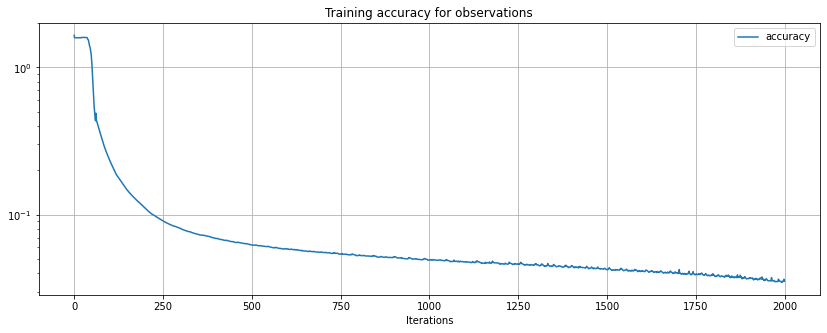

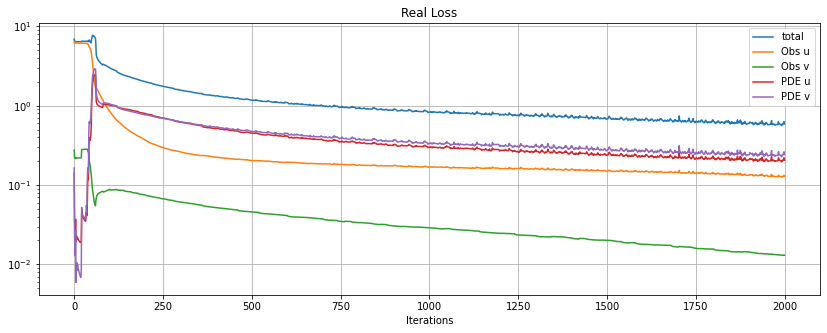

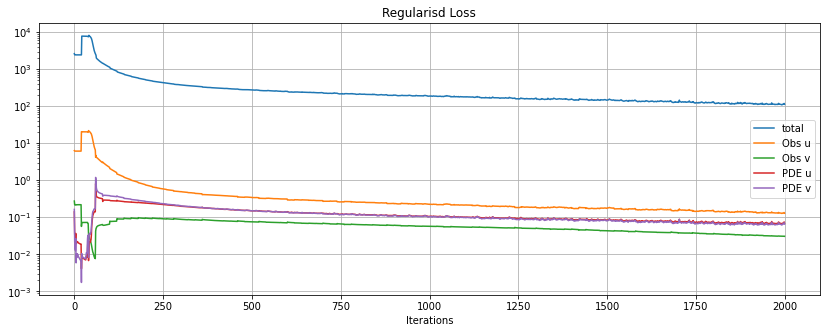

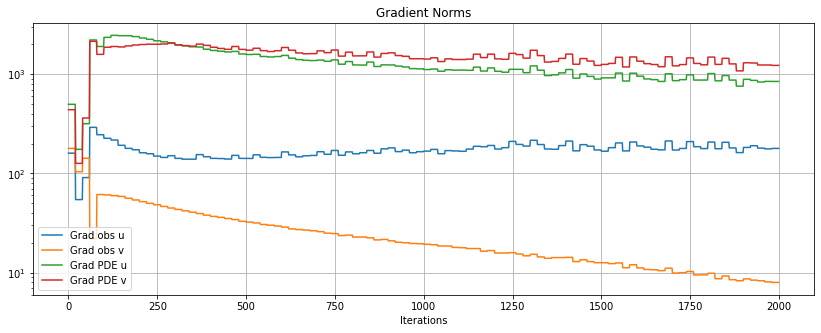

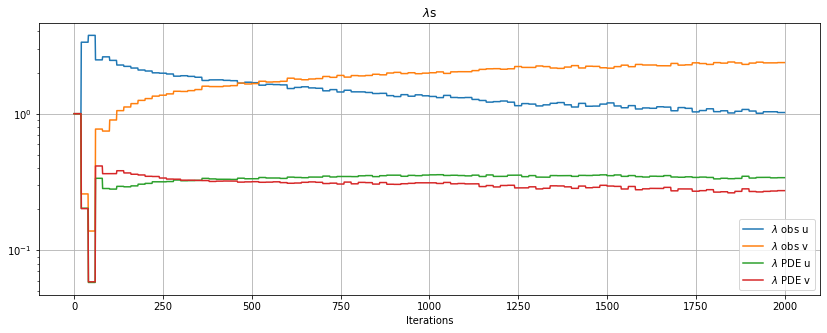

In [9]:
plot_result(results3_1)

In [63]:
model3.optimizer.lr.assign(2.5e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.00025>

In [64]:
results3_2 = model3.train(epochs=200+1,
                      batch_size=dataset.x_size//380,
                      dataset=dataset,
                      print_interval=10,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 20
                     )


Start of epoch 0
Training observations acc over epoch: 0.0322781578
total loss: 0.4840717539, total regularisd loss (sum of batches): 94.4522916826
obs u loss: 0.1163890541, obs v loss: 0.0127235690
pde u loss: 0.1676925989, pde v loss: 0.1872665317
lambda obs u: 0.9696320442, lambda obs v: 2.4387211953
lambda pde u: 0.3320605526, lambda pde v: 0.2595862079

Time taken: 113.12s

Start of epoch 10
Training observations acc over epoch: 0.0326887965
total loss: 0.5080922170, total regularisd loss (sum of batches): 97.3856840410
obs u loss: 0.1182746592, obs v loss: 0.0124805028
pde u loss: 0.1773264070, pde v loss: 0.2000106480
lambda obs u: 0.9696320442, lambda obs v: 2.4387211953
lambda pde u: 0.3320605526, lambda pde v: 0.2595862079

Time taken: 311.68s

Start of epoch 20
Training observations acc over epoch: 0.0324047469
total loss: 0.5051628569, total regularisd loss (sum of batches): 96.6937161107
obs u loss: 0.1172730712, obs v loss: 0.0123458027
pde u loss: 0.1766595618, pde v lo

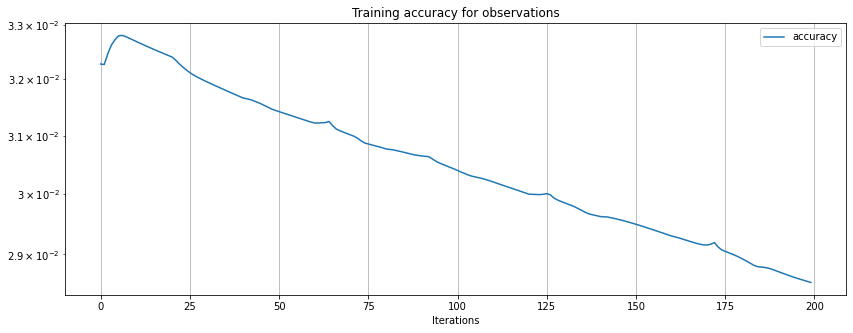

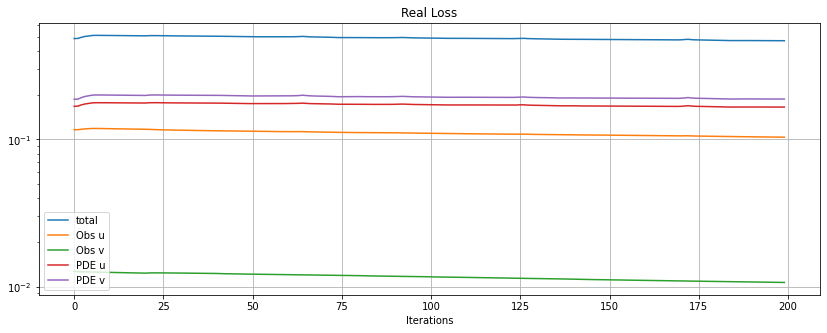

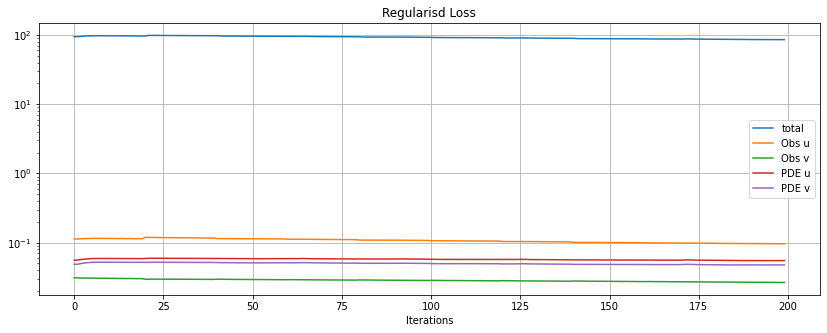

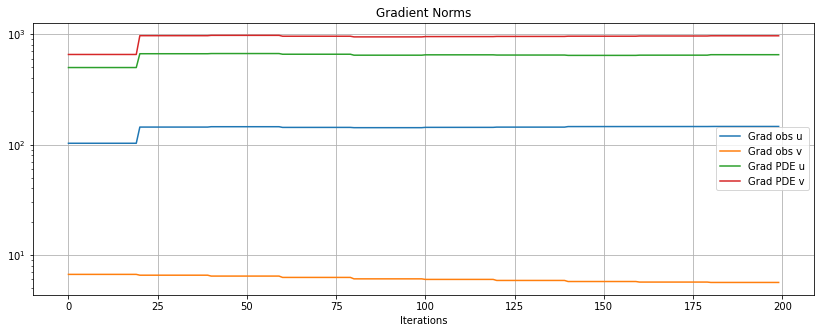

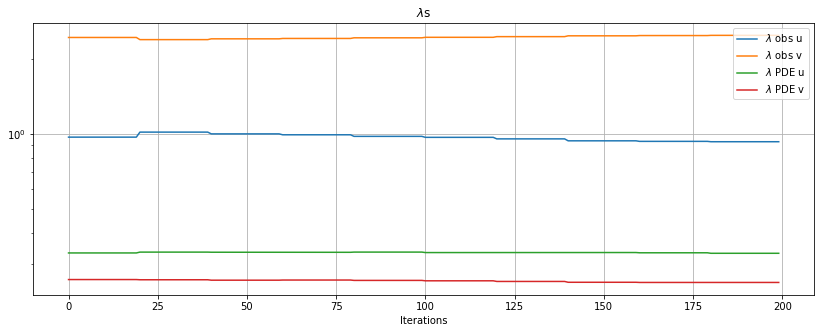

In [68]:
plot_result(results3_2)

In [94]:
results3_3 = model3.train(epochs=1200+1,
                      batch_size=dataset.x_size//380,
                      dataset=dataset,
                      print_interval=10,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 20
                     )


Start of epoch 0
Training observations acc over epoch: 0.0285328384
total loss: 0.4678100458, total regularisd loss (sum of batches): 84.7940857677
obs u loss: 0.1034920889, obs v loss: 0.0106392991
pde u loss: 0.1656176198, pde v loss: 0.1880610381
lambda obs u: 0.9107003373, lambda obs v: 2.5079162851
lambda pde u: 0.3312615610, lambda pde v: 0.2501218165

Time taken: 112.90s

Start of epoch 10
Training observations acc over epoch: 0.0283601247
total loss: 0.4649730639, total regularisd loss (sum of batches): 84.2425643119
obs u loss: 0.1029159118, obs v loss: 0.0105245697
pde u loss: 0.1643992361, pde v loss: 0.1871333464
lambda obs u: 0.9107003373, lambda obs v: 2.5079162851
lambda pde u: 0.3312615610, lambda pde v: 0.2501218165

Time taken: 313.07s

Start of epoch 20
Training observations acc over epoch: 0.0281619262
total loss: 0.4623293477, total regularisd loss (sum of batches): 83.7114446626
obs u loss: 0.1022099763, obs v loss: 0.0104377007
pde u loss: 0.1635083252, pde v lo


Start of epoch 220
Training observations acc over epoch: 0.0251143556
total loss: 0.4219619763, total regularisd loss (sum of batches): 73.3083929888
obs u loss: 0.0916249703, obs v loss: 0.0088324323
pde u loss: 0.1488928301, pde v loss: 0.1726117435
lambda obs u: 0.8428109597, lambda obs v: 2.5526960290
lambda pde u: 0.3479374553, lambda pde v: 0.2565555560

Time taken: 396.52s

Start of epoch 230
Training observations acc over epoch: 0.0251756068
total loss: 0.4217950451, total regularisd loss (sum of batches): 74.5562242723
obs u loss: 0.0918744623, obs v loss: 0.0088279870
pde u loss: 0.1488237782, pde v loss: 0.1722688176
lambda obs u: 0.8428109597, lambda obs v: 2.5526960290
lambda pde u: 0.3479374553, lambda pde v: 0.2565555560

Time taken: 313.15s

Start of epoch 240
Training observations acc over epoch: 0.0249764081
total loss: 0.4169718047, total regularisd loss (sum of batches): 73.8081341424
obs u loss: 0.0911357573, obs v loss: 0.0087699093
pde u loss: 0.1470838240, pde 


Start of epoch 440
Training observations acc over epoch: 0.0227104146
total loss: 0.3868540005, total regularisd loss (sum of batches): 66.3048705571
obs u loss: 0.0832158822, obs v loss: 0.0076257659
pde u loss: 0.1366657915, pde v loss: 0.1593465609
lambda obs u: 0.8049310437, lambda obs v: 2.5810442350
lambda pde u: 0.3526297495, lambda pde v: 0.2613949718

Time taken: 396.54s

Start of epoch 450
Training observations acc over epoch: 0.0226314366
total loss: 0.3850294935, total regularisd loss (sum of batches): 66.8943855088
obs u loss: 0.0829036773, obs v loss: 0.0076220637
pde u loss: 0.1361974567, pde v loss: 0.1583062959
lambda obs u: 0.8049310437, lambda obs v: 2.5810442350
lambda pde u: 0.3526297495, lambda pde v: 0.2613949718

Time taken: 313.17s

Start of epoch 460
Training observations acc over epoch: 0.0225026235
total loss: 0.3830203592, total regularisd loss (sum of batches): 66.5451385123
obs u loss: 0.0824281274, obs v loss: 0.0075823763
pde u loss: 0.1357903855, pde 


Start of epoch 660
Training observations acc over epoch: 0.0207161922
total loss: 0.3546563628, total regularisd loss (sum of batches): 62.7248037174
obs u loss: 0.0759433739, obs v loss: 0.0069213645
pde u loss: 0.1260980700, pde v loss: 0.1456935543
lambda obs u: 0.7980789004, lambda obs v: 2.5619775395
lambda pde u: 0.3675061119, lambda pde v: 0.2724374482

Time taken: 396.54s

Start of epoch 670
Training observations acc over epoch: 0.0206491258
total loss: 0.3548000972, total regularisd loss (sum of batches): 62.4845574546
obs u loss: 0.0757022339, obs v loss: 0.0068942586
pde u loss: 0.1261097452, pde v loss: 0.1460938595
lambda obs u: 0.7980789004, lambda obs v: 2.5619775395
lambda pde u: 0.3675061119, lambda pde v: 0.2724374482

Time taken: 313.19s

Start of epoch 680
Training observations acc over epoch: 0.0206973478
total loss: 0.3573011576, total regularisd loss (sum of batches): 62.8035123872
obs u loss: 0.0759108501, obs v loss: 0.0068785471
pde u loss: 0.1268763167, pde 


Start of epoch 880
Training observations acc over epoch: 0.0194194354
total loss: 0.3442417988, total regularisd loss (sum of batches): 58.3349458895
obs u loss: 0.0714120350, obs v loss: 0.0062656940
pde u loss: 0.1220108676, pde v loss: 0.1445532021
lambda obs u: 0.7602424779, lambda obs v: 2.6372799600
lambda pde u: 0.3515218596, lambda pde v: 0.2509557024

Time taken: 396.76s

Start of epoch 890
Training observations acc over epoch: 0.0190791693
total loss: 0.3377329857, total regularisd loss (sum of batches): 56.0442757276
obs u loss: 0.0701283817, obs v loss: 0.0061883117
pde u loss: 0.1199527043, pde v loss: 0.1414635881
lambda obs u: 0.7602424779, lambda obs v: 2.6372799600
lambda pde u: 0.3515218596, lambda pde v: 0.2509557024

Time taken: 313.29s

Start of epoch 900
Training observations acc over epoch: 0.0190564077
total loss: 0.3414207909, total regularisd loss (sum of batches): 56.4072817622
obs u loss: 0.0700667814, obs v loss: 0.0061588645
pde u loss: 0.1212063934, pde 


Start of epoch 1100
Training observations acc over epoch: 0.0179258157
total loss: 0.3162235213, total regularisd loss (sum of batches): 53.4342459159
obs u loss: 0.0658925268, obs v loss: 0.0058107600
pde u loss: 0.1124111851, pde v loss: 0.1321090494
lambda obs u: 0.7755948381, lambda obs v: 2.5719220935
lambda pde u: 0.3772960661, lambda pde v: 0.2751870023

Time taken: 396.52s

Start of epoch 1110
Training observations acc over epoch: 0.0182743017
total loss: 0.3278474280, total regularisd loss (sum of batches): 56.7880747075
obs u loss: 0.0672222083, obs v loss: 0.0058749904
pde u loss: 0.1165716057, pde v loss: 0.1381786235
lambda obs u: 0.7755948381, lambda obs v: 2.5719220935
lambda pde u: 0.3772960661, lambda pde v: 0.2751870023

Time taken: 313.20s

Start of epoch 1120
Training observations acc over epoch: 0.0178609528
total loss: 0.3148141516, total regularisd loss (sum of batches): 54.9149183047
obs u loss: 0.0655889581, obs v loss: 0.0058548318
pde u loss: 0.1119411587, p

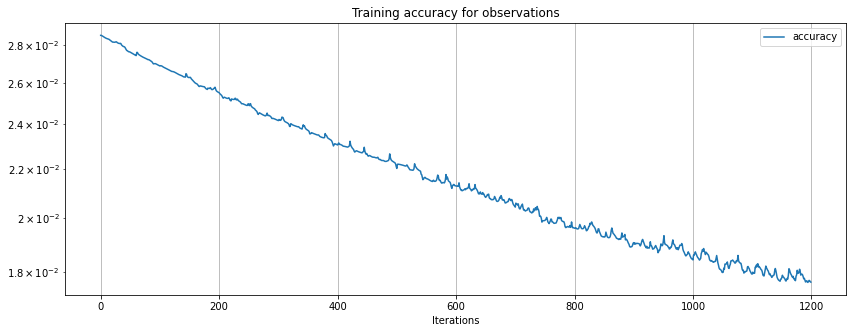

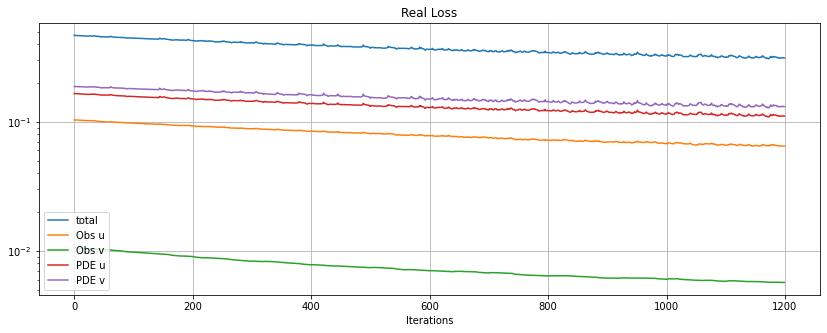

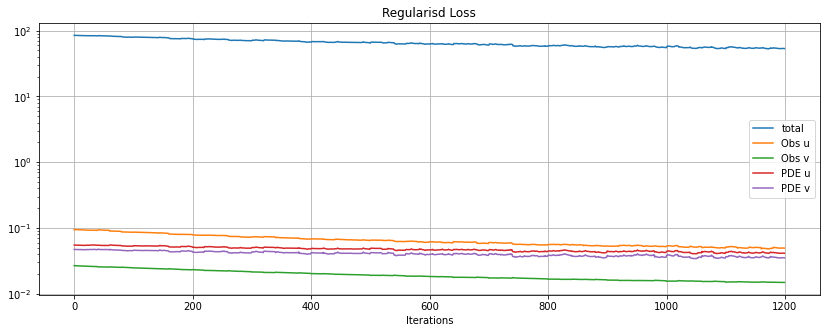

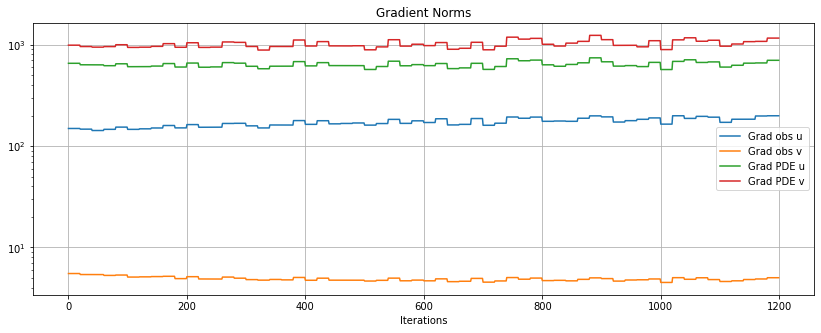

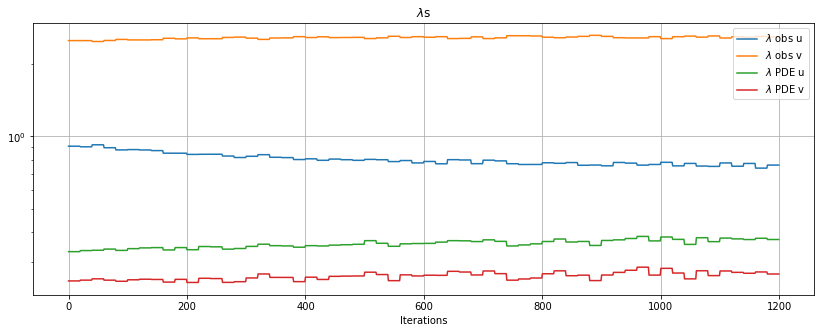

In [96]:
plot_result(results3_3)

In [95]:
model3.save("/end/home/rh2310/save_tests", "model_100_by_100_dense_params")

In [ ]:
## model3 = tu.TINN.restore("/end/home/rh2310/save_tests", "model_100_by_100_dense_params")
pinn3 = model3.pinn
pde_loss3 = model3.pde_residual

640.0
2.0500405063689455 2.8141502795583957


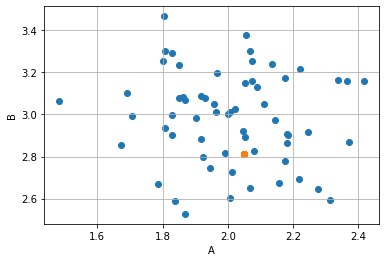

In [131]:
x_domain = dataset.simulations[0].L[0] * np.linspace(0, 1, dataset.simulations[0].n[0])
y_domain = dataset.simulations[0].L[1] * np.linspace(0, 1, dataset.simulations[0].n[1])
x_size = dataset.simulations[0].n[0]
y_size = dataset.simulations[0].n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ls_ts[0][T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ls_ts[0][T_test_index], N2)  # 1 x N2

#A_test = np.repeat(dataset.simulations[0].parameters["A"] + 1, N2)
A_M = 2
B_M = 3
std_AB = .1
(A, B ) = np.random.normal((A_M, B_M), (std_AB, std_AB), size=2)
while A in As and B in Bs and std_AB > 0:
    (A, B ) = np.random.normal((A_M, B_M), (std_AB, std_AB), size=2)
    
print(A, B)
A_test = np.repeat(A, N2)
#B_test = np.repeat(dataset.simulations[0].parameters["B"] + 1, N2)
B_test = np.repeat(B, N2)

plt.scatter(As, Bs)
plt.scatter(A_test, B_test)
plt.xlabel("A")
plt.ylabel("B")
plt.grid()
plt.show()

In [132]:
output_test = pinn3(np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

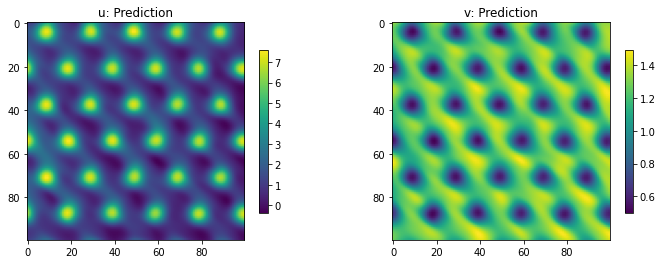

In [133]:
node_names = ["u", "v"]
# _ = plt.figure(figsize=(12,4))
# for i, name in enumerate(node_names):
#     plt.subplot(1, 2, i+1)
#     plt.title(f"{name}: Observation")
#     plt.imshow(data[i,:, :, T_test_index])
#     plt.colorbar(shrink=.75)

# plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    #rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    #plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    plt.title(f"{name}: Prediction")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [134]:
test_outputs, test_pde_u, test_pde_v = pde_loss3.residual(pinn3, np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T)
test_outputs = test_outputs.numpy()
test_pde_u = test_pde_u.numpy().reshape((x_size, y_size))
test_pde_v = test_pde_v.numpy().reshape((x_size, y_size))

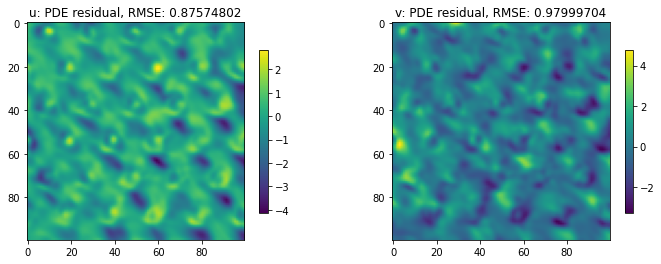

In [135]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

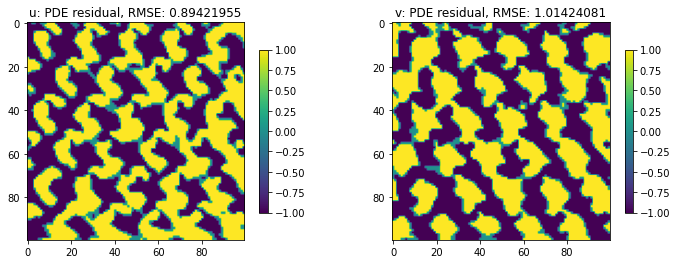

In [120]:
max_L = .10
min_L = -.10

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()